In [ ]:
%matplotlib inline


# RGB to HSV


This example illustrates how RGB to HSV (Hue, Saturation, Value) conversion
[1]_ can be used to facilitate segmentation processes.

Usually, objects in images have distinct colors (hues) and luminosities, so
that these features can be used to separate different areas of the image.
In the RGB representation the hue and the luminosity are expressed as a linear
combination of the R,G,B channels, whereas they correspond to single channels
of the HSV image (the Hue and the Value channels). A simple segmentation of the
image can then be effectively performed by a mere thresholding of the HSV
channels.

.. [1] https://en.wikipedia.org/wiki/HSL_and_HSV


In [4]:
import matplotlib.pyplot as plt
import cv2
from skimage import data
from skimage.color import rgb2hsv

We first load the RGB image and extract the Hue and Value channels:



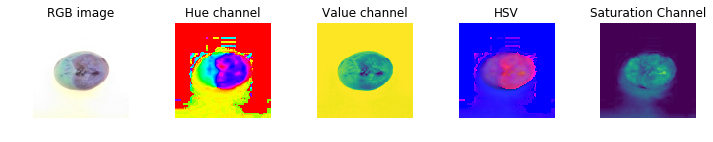

In [5]:

rgb_img = cv2.imread("72.jpg")
hsv_img = rgb2hsv(rgb_img)
hue_img = hsv_img[:, :, 0]
setu_img = hsv_img[:, :, 1]
value_img = hsv_img[:, :, 2]

fig, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(ncols=5, figsize=(10, 2))

ax0.imshow(rgb_img)
ax0.set_title("RGB image")
ax0.axis('off')
ax1.imshow(hue_img, cmap='hsv')
ax1.set_title("Hue channel")
ax1.axis('off')
ax2.imshow(value_img)
ax2.set_title("Value channel")
ax2.axis('off')
ax3.imshow(hsv_img)
ax3.set_title("HSV")
ax3.axis('off')
ax4.imshow(setu_img)
ax4.set_title("Saturation Channel")
ax4.axis('off')
fig.tight_layout()

We then set a threshold on the Hue channel to separate the cup from the
background:



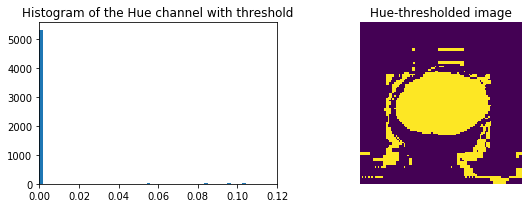

In [6]:
hue_threshold = 0.2
binary_img = hue_img > hue_threshold

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 3))

ax0.hist(hue_img.ravel(), 512)
ax0.set_title("Histogram of the Hue channel with threshold")
ax0.axvline(x=hue_threshold, color='r', linestyle='dashed', linewidth=2)
ax0.set_xbound(0, 0.12)
ax1.imshow(binary_img)
ax1.set_title("Hue-thresholded image")
ax1.axis('off')

fig.tight_layout()

We finally perform an additional thresholding on the Value channel to partly
remove the shadow of the cup:



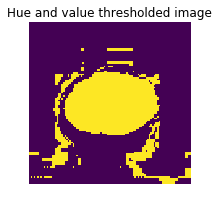

In [7]:
fig, ax0 = plt.subplots(figsize=(4, 3))

value_threshold = 0.10
binary_img = (hue_img > hue_threshold) | (value_img < value_threshold)

ax0.imshow(binary_img)
ax0.set_title("Hue and value thresholded image")
ax0.axis('off')

fig.tight_layout()
plt.show()

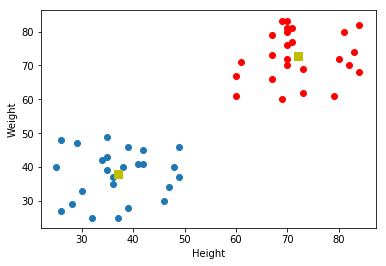

In [8]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

X = np.random.randint(25,50,(25,2))  # (weight, height)
Y = np.random.randint(60,85,(25,2))  
Z = np.vstack((X,Y))

# convert to np.float32
Z = np.float32(Z)

# define criteria and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
ret,label,center=cv2.kmeans(Z,2,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Now separate the data, Note the ravel()
A = Z[label.ravel()==0]
B = Z[label.ravel()==1]

# Plot the data
plt.scatter(A[:,0],A[:,1])
plt.scatter(B[:,0],B[:,1],c = 'r')
plt.scatter(center[:,0],center[:,1],s = 80,c = 'y', marker = 's')
plt.xlabel('Height'),plt.ylabel('Weight')
plt.show()

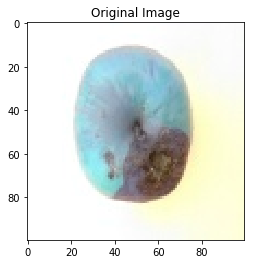

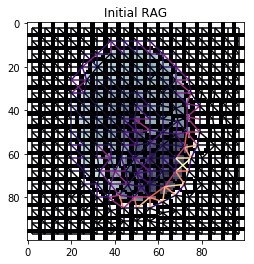

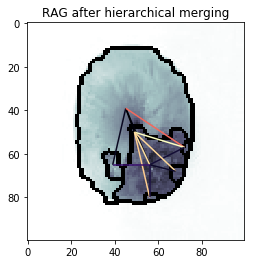

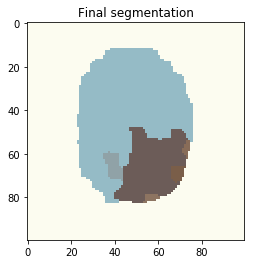

In [15]:
from skimage import data, segmentation, filters, color
from skimage.future import graph
from matplotlib import pyplot as plt
import cv2


def weight_boundary(graph, src, dst, n):
    """
    Handle merging of nodes of a region boundary region adjacency graph.

    This function computes the `"weight"` and the count `"count"`
    attributes of the edge between `n` and the node formed after
    merging `src` and `dst`.


    Parameters
    ----------
    graph : RAG
        The graph under consideration.
    src, dst : int
        The vertices in `graph` to be merged.
    n : int
        A neighbor of `src` or `dst` or both.

    Returns
    -------
    data : dict
        A dictionary with the "weight" and "count" attributes to be
        assigned for the merged node.

    """
    default = {'weight': 0.0, 'count': 0}

    count_src = graph[src].get(n, default)['count']
    count_dst = graph[dst].get(n, default)['count']

    weight_src = graph[src].get(n, default)['weight']
    weight_dst = graph[dst].get(n, default)['weight']

    count = count_src + count_dst
    return {
        'count': count,
        'weight': (count_src * weight_src + count_dst * weight_dst)/count
    }


def merge_boundary(graph, src, dst):
    """Call back called before merging 2 nodes.

    In this case we don't need to do any computation here.
    """
    pass

#img = data.coffee()
img = cv2.imread("39.jpg")
edges = filters.sobel(color.rgb2gray(img))
labels = segmentation.slic(img, compactness=30, n_segments=300)
g = graph.rag_boundary(labels, edges)

plt.imshow(img)
plt.title("Original Image")
plt.show()

graph.show_rag(labels, g, img)
plt.title('Initial RAG')

labels2 = graph.merge_hierarchical(labels, g, thresh=0.08, rag_copy=False,
                                   in_place_merge=True,
                                   merge_func=merge_boundary,
                                   weight_func=weight_boundary)

graph.show_rag(labels, g, img)
plt.title('RAG after hierarchical merging')

plt.figure()
out = color.label2rgb(labels2, img, kind='avg')
plt.imshow(out)
plt.title('Final segmentation')

plt.show()